# Сложность вычислений, 2018.
## Реализация алгоритма Minimum edge expansion by Leighton and Rao.

In [288]:
import networkx as nx
from math import ceil
from math import inf
import sys
import numpy as np
import queue
import matplotlib.pyplot as plt
import pulp
import pylab

### Находим функцию расстояния с помощью линейного программирования.

In [289]:
def find_max_flow(G):
    model = pulp.LpProblem("Max flow", pulp.LpMinimize)

    # Linear Programming for finding max flow
    nodes = G.nodes
    lvars = pulp.LpVariable.dicts("dist",
                                         ((i, j) for i in nodes for j in nodes if i < j),
                                         lowBound=0,
                                         cat='Continuous')

    # Objective Function
    model += (
        pulp.lpSum([lvars[e] for e in G.edges])
    )

    # Constraints
    model += pulp.lpSum(lvars) >= 1

    for i in nodes:
        for j in nodes:
            for k in nodes:
                if (i, j) in lvars and (i, k) in lvars and (k, j) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(i, k)] - lvars[(k, j)]]) <= 0
                if (i, j) in lvars and (i, k) in lvars and (j, k) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(i, k)] - lvars[(j, k)]]) <= 0
                if (i, j) in lvars and (k, i) in lvars and (k, j) in lvars:
                    model += pulp.lpSum([lvars[(i, j)] - lvars[(k, i)] - lvars[(k, j)]]) <= 0

    # Solve problem
    model.solve()
    pulp.LpStatus[model.status]

    d = {}
    for var in lvars:
        d[var] = lvars[var].varValue

    W = pulp.value(model.objective)
    return W, d

### Класс для нахождения минимального разреза. Выводит всю необходимую информацию, рисует граф.

In [290]:
class LeightonRaoMinCut:
    def __init__(self, G):
        self.G = G
        self.W, self.d = find_max_flow(G)
        self.C = len(G.edges)
        self.c = 1
        self.n = len(G)
        self.delta = 1 / (2 * self.n**2)
        dist = {}
        for e in G.edges:
            dist[e] = {'dist' : self.d[e]}
        nx.set_edge_attributes(self.G, dist)
        
    def find_cut(self):
        print("============================================================")
        print("Input Graph:")
        print("W = f = {}".format(self.W))
        
        self.partition()
        self.divide_in_two()
        
        print("First part: ", self.first)
        print("Second part: ", self.second)
        
        print("Coloured by cut graph:")
        print("Ratio: ", nx.cut_size(self.G, self.first) / min(len(self.first), len(self.second)))
        plt.figure(figsize=(6, 6))
        pos=nx.spring_layout(self.G)
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.first, node_color='r')
        nx.draw_networkx_nodes(self.G, pos, nodelist=self.second, node_color='b')
        nx.draw_networkx_labels(self.G, pos)
        nx.draw_networkx_edges(self.G, pos)
        plt.axis('off')
        plt.show()
        print("============================================================")
        
    def partition(self):
        
        self.parts = []
        print("delta ", self.delta)
        print("magick number ", 4 * self.W * np.log(self.n) / self.C)
        if self.delta <= 4 * self.W * np.log(self.n) / self.C:
            print("First case...")
            for n in self.G:
                self.parts.append([n])
        else:
            print("Second case...")
            G1 = nx.Graph()
            for e in self.G.edges:
                e_num = ceil(self.C * self.d[e] / self.W)
                if e_num == 0:
                    G1.add_edge(e[0], e[1], weight=0)
                else:
                    if e_num == 1:
                        G1.add_edge(e[0], e[1],weight=1)
                    else:
                        G1.add_edge(e[0], "{}_{}_{}".format(e[0], e[1], 0), weight=1)
                        for i in range(e_num - 1):
                            G1.add_edge("{}_{}_{}".format(e[0], e[1], i), \
                                        "{}_{}_{}".format(e[0], e[1], i + 1), weight=1)
                        G1.add_edge("{}_{}_{}".format(e[0], e[1], e_num - 1), e[1], weight=1)
                   
            # print("G+ graph")
            # plt.figure(figsize=(12, 12))
            # nx.draw(G1, with_labels=True)
            # plt.show()
            
            self.G1 = G1.copy()
            C0 = 2 * self.C / self.n
            eps = self.W * np.log(self.n) / (self.delta * self.C)
            while True:
                v = -1
                for n in self.G:
                    if n in G1:
                        v = n
                if v == -1:
                    break
                dist = {}
                self.bfs(G1, v, dist)
                #print("dist {}, node {}".format(dist, v))
                C_prev = C0
                v_prev = [v]
                for i in range(1, len(G1.edges) + 1):
                    v_new = [j for j in G1 if j in dist and dist[j] <= i]
                    #print("v_new {}".format(v_new))
                    Ci = len(G1.subgraph(v_new).edges)
                    if (Ci < (1 + eps) * C_prev):
                        self.parts.append([i for i in v_prev if i in self.G])
                        #print("Ci {}, (1+e)C_prev {}".format(Ci, (1 + eps) * C_prev))
                        #print("v_prev {} {}".format(v_prev, i))
                        G1.remove_nodes_from(v_prev)
                        break
                    C_prev = Ci
                    v_prev = v_new
        
    def divide_in_two(self):
        for part in self.parts:
            if len(part) >= 2 * self.n / 3:
                print("Found large (more then 2/3) component...")
                self.divide_by_T(part)
                return
        print("All components have less then 1/3 of nodes...")
        self.parts.sort(key=self.sort_key)
        self.first = []
        self.second = []
        while self.parts:
            if len(self.first) < self.n / 3 and len(self.first) + len(self.parts[-1]) < 2 * self.n / 3:
                self.first += self.parts.pop(-1)
            else:
                self.second += self.parts.pop(-1)
                
    def divide_by_T(self, T):
        dist = {}
        self.bfs(self.G1, None, dist, T)
        R = inf
        v_prev = T
        v_len_prev = len(T)
        for i in range(1, len(self.G1.edges) + 1):
            v_new = [j for j in self.G1 if j in dist and j in self.G and dist[j] <= i]
            v_len = len(v_new)
            if len(self.G) == v_len_prev:
                break
            Ri = (v_len - v_len_prev) / (v_len_prev * (len(self.G) - v_len_prev))
            R = min(R, Ri)
            if Ri == R:
                self.first = v_prev
            v_len_prev = v_len
            v_prev = v_new
        self.second = [i for i in self.G if i not in self.first]
                
    def sort_key(self, list_):
        return len(list_)
        
    def bfs(self, G, s, dist, T = None):
        q = queue.Queue()
        if s is not None:
            q.put(s)
            dist[s] = 0
        visit = {}
        for v in G:
            visit[v] = False
        if T is not None:
            for v in T:
                dist[v] = 0
                q.put(v)
                visit[v] = True
        while not q.empty():
            v = q.get()
            visit[v] = True
            for u in G[v]:
                if not visit[u]:
                    q.put(u)
                    dist[u] = dist[v] + G[v][u]['weight']

### Примеры на графах.

In [291]:
G0 = nx.Graph()

n = 10
for i in range(n):
    for j in range(i + 1):
        G0.add_edge(j, i + 1)
G0.add_edge(n, 0)
for i in range(n):
    for j in range(i + 1):
        G0.add_edge(n + j + 1, i + n + 2)
G0.add_edge(2 * n + 1, n + 1)
G0.add_edge(0, 2 * n + 1)

### Гантелька

Input Graph:
W = f = 0.0082644628
delta  0.0010330578512396695
magick number  0.0009205695628468663
Second case...
All components have less then 1/3 of nodes...
First part:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Second part:  [21, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Coloured by cut graph:
Ratio:  0.09090909090909091


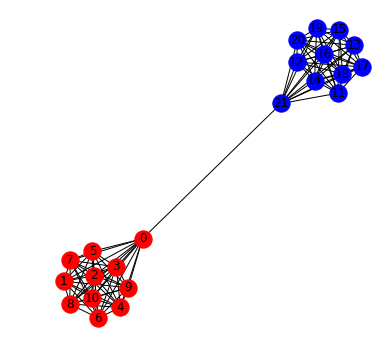

In [292]:
solver = LeightonRaoMinCut(G0)
solver.find_cut()

### Какие-то простые, небольшие графы

Input Graph:
W = f = 1.0
delta  0.125
magick number  2.772588722239781
First case...
All components have less then 1/3 of nodes...
First part:  [1]
Second part:  [0]
Coloured by cut graph:
Ratio:  1.0


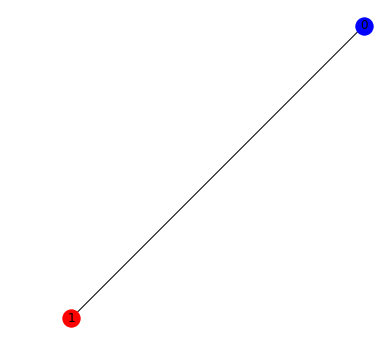

Input Graph:
W = f = 0.5
delta  0.05555555555555555
magick number  1.0986122886681098
First case...
All components have less then 1/3 of nodes...
First part:  [2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.0


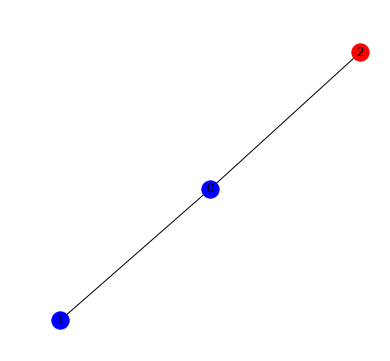

Input Graph:
W = f = 1.0
delta  0.05555555555555555
magick number  1.4648163848908131
First case...
All components have less then 1/3 of nodes...
First part:  [2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  2.0


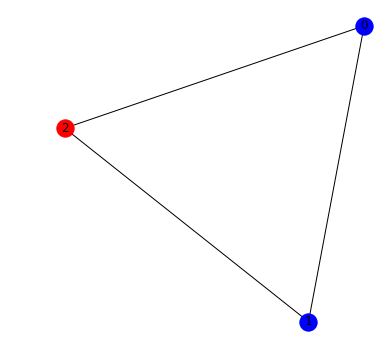

Input Graph:
W = f = 0.33333333
delta  0.03125
magick number  0.6161308210030875
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.0


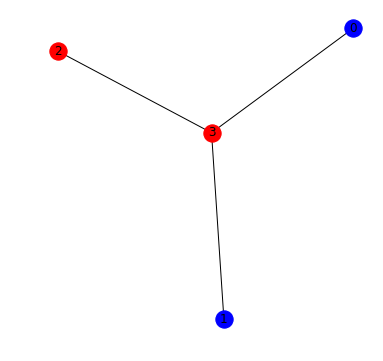

Input Graph:
W = f = 0.25
delta  0.03125
magick number  0.46209812037329684
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.0


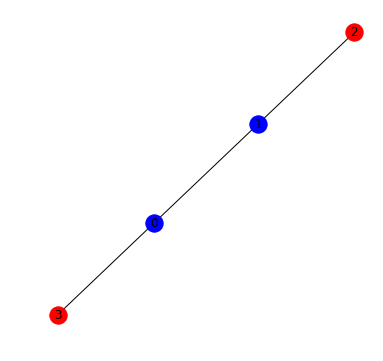

Input Graph:
W = f = 0.33333333
delta  0.03125
magick number  0.46209811575231563
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.5


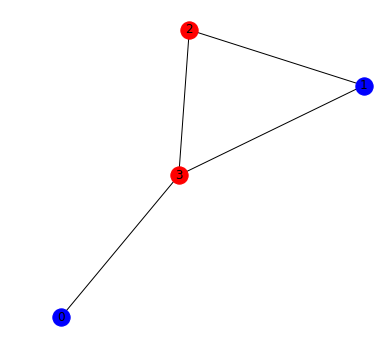

Input Graph:
W = f = 0.5
delta  0.03125
magick number  0.6931471805599453
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.0


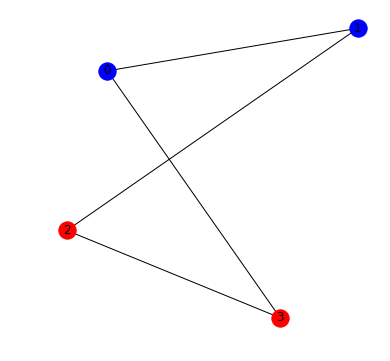

Input Graph:
W = f = 0.66666666
delta  0.03125
magick number  0.739356985203705
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  1.5


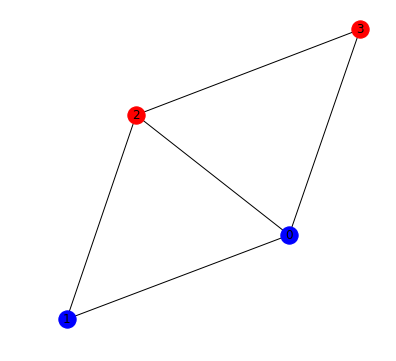

Input Graph:
W = f = 0.99999999
delta  0.03125
magick number  0.9241962315046313
First case...
All components have less then 1/3 of nodes...
First part:  [3, 2]
Second part:  [1, 0]
Coloured by cut graph:
Ratio:  2.0


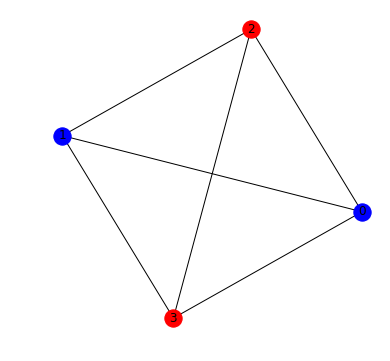

Input Graph:
W = f = 0.25
delta  0.02
magick number  0.40235947810852507
First case...
All components have less then 1/3 of nodes...
First part:  [4, 3]
Second part:  [2, 1, 0]
Coloured by cut graph:
Ratio:  1.5


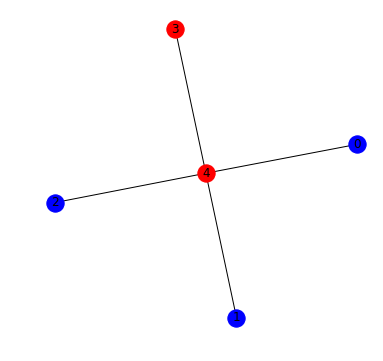

Input Graph:
W = f = 0.16666667
delta  0.02
magick number  0.26823965743714306
First case...
All components have less then 1/3 of nodes...
First part:  [4, 3]
Second part:  [2, 1, 0]
Coloured by cut graph:
Ratio:  1.5


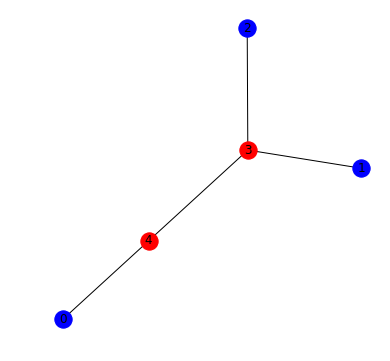

In [293]:
i = 0
for G in nx.graph_atlas_g():
    if i > 10:
        break
    if len(G) <= 1 or not nx.is_connected(G):
        continue
    i += 1
    solver = LeightonRaoMinCut(G)
    solver.find_cut()

Input Graph:
W = f = 0.35714285999999973
delta  0.00125
magick number  0.04279617567885495
First case...
All components have less then 1/3 of nodes...
First part:  [19, 18, 17, 16, 15, 14, 13]
Second part:  [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Coloured by cut graph:
Ratio:  10.0


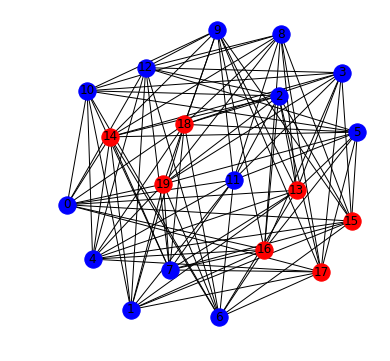

In [294]:
Knm = nx.complete_bipartite_graph(10, 10)
solver = LeightonRaoMinCut(Knm)
solver.find_cut()

### Леденец

Input Graph:
W = f = 0.004
delta  0.00016528925619834712
magick number  5.212791135261751e-05
Second case...
Found large (more then 2/3) component...
First part:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Second part:  [50, 51, 52, 53, 54]
Coloured by cut graph:
Ratio:  0.2


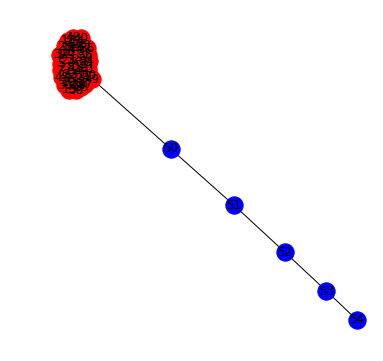

In [295]:
G = nx.lollipop_graph(50, 5)
solver = LeightonRaoMinCut(G)
solver.find_cut()

Input Graph:
W = f = 0.137931036
delta  0.0005555555555555556
magick number  0.009672797494704094
First case...
All components have less then 1/3 of nodes...
First part:  [29, 28, 27, 26, 25, 24, 23, 22, 21, 20]
Second part:  [19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Coloured by cut graph:
Ratio:  15.5


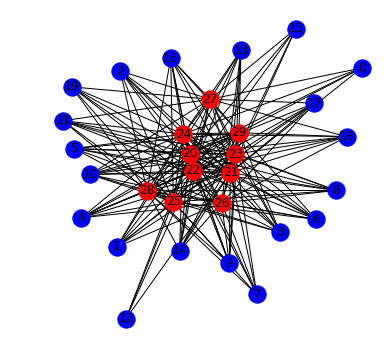

In [296]:
G = nx.powerlaw_cluster_graph(30, 20, 0.1)
solver = LeightonRaoMinCut(G)
solver.find_cut()